# Initialization

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import matplotlib.cm as cm
plt.gray();

import tensorflow as tf
tf.set_random_seed(0)
import time

#load up MNIST data
import input_data
mnist_data = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
IMAGE_HEIGHT = 28
IMAGE_WIDTH = 28
IMAGE_CHANNELS = 1
IMAGE_SIZE = IMAGE_HEIGHT*IMAGE_WIDTH
NUM_V = IMAGE_SIZE
NUM_H = NUM_V
LOGDIR = 'RBM'
BATCH_SIZE = 20 #10
LEARN_RATE = 0.1 #0.01 #0.25 #0.1 #10.0
W_STDDEV = 0.01 #2.0
WEIGHT_COST = 0.01

In [3]:
## use full dataset to help with initalizing biases
init_batch = mnist_data.train.next_batch(mnist_data.train.num_examples)[0][:,0:IMAGE_SIZE]
prob_data = np.mean(init_batch, axis=0)
vis_init = np.nan_to_num(np.log(prob_data/(1-prob_data)))
vis_init[np.abs(vis_init)>1.0e38]=-1000 #rescale gigantic biases

/home/coolguy/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [4]:
#define placeholders, functions, and variables for visible/hidden units

#joint global variables
with tf.name_scope('joint') as scope:
    joint_scope = scope
    #weights between hidden and visible layers
    W = tf.Variable(tf.truncated_normal(shape=[NUM_V,NUM_H], stddev=W_STDDEV), name='weights') 

#placeholders
with tf.name_scope('visible') as scope:
    vis_scope = scope
    v_probabilities = tf.placeholder("float", shape=[None, NUM_V], name='vis_probs')
    v_state = tf.placeholder("float", shape=[None, NUM_V], name='vis_state')
    
with tf.name_scope('hidden') as scope:
    hid_scope = scope    
    h_probabilities = tf.placeholder("float", shape=[None, NUM_H], name='hid_probs')
    h_state = tf.placeholder("float", shape=[None, NUM_H], name='hid_state')

with tf.name_scope(vis_scope) as scope:
    #bias variable
    a = tf.Variable(vis_init, name='bias')
    #activation function
    v_prob = tf.nn.sigmoid(tf.matmul(h_state, W, transpose_b=True)+a, name="visible_probs")
    #conversion function for probabilities to binary values
    v_prob_to_state = tf.to_float(tf.less_equal(tf.random_uniform(shape=tf.TensorShape([BATCH_SIZE,NUM_V])), v_probabilities), name='prob_to_state')
    #convert to form more conducive to tensor product
    v_reshaped = tf.reshape(v_state, [BATCH_SIZE, NUM_V, 1], name='vis_reshaped')
    #average over training set
    v_mean = tf.reduce_mean(v_state,0, name='vis_batch_mean')
    
with tf.name_scope(hid_scope) as scope:
    #bias variable
    b = tf.Variable(tf.zeros(shape=[NUM_H]), name='bias')
    #activation function
    h_prob = tf.nn.sigmoid(tf.matmul(v_state, W,)+b, name="hidden_probs")
    #conversion function for probabilities to binary values
    h_prob_to_state = tf.to_float(tf.less_equal(tf.random_uniform(shape=tf.TensorShape([BATCH_SIZE,NUM_H])), h_probabilities), name='prob_to_state')
    #convert to form more conducive to tensor product
    h_reshaped = tf.reshape(h_state, [BATCH_SIZE, 1, NUM_H], name='hid_reshaped')
    h_mean = tf.reduce_mean(h_state,0, name='hid_batch_mean')

with tf.name_scope(joint_scope) as scope: #to do: fix this
    v_times_h = tf.batch_matmul(v_reshaped,h_reshaped, name='vh_outer') 
    vh_expval = tf.reduce_mean(v_times_h,0, name='vh_batch_mean')

In [5]:
#cost function 
with tf.name_scope('cost') as scope:
    #placeholders to hold the expectation values for feeding into cost function
    v_expval_data = tf.placeholder("float", shape=[NUM_V,], name='vis_expval_data')
    h_expval_data = tf.placeholder("float", shape=[NUM_H,], name='hid_expval_data')
    vh_expval_data = tf.placeholder("float", shape=[NUM_V, NUM_H], name='vh_expval_data')
    v_expval_model = tf.placeholder("float", shape=[NUM_V,], name='vis_expval_model')
    h_expval_model = tf.placeholder("float", shape=[NUM_H,], name='hid_expval_model')
    vh_expval_model = tf.placeholder("float", shape=[NUM_V, NUM_H], name='vh_expval_model')

    a_term = tf.reduce_sum(tf.mul(a, v_expval_data - v_expval_model), name = 'a_term')
    b_term = tf.reduce_sum(tf.mul(b, h_expval_data - h_expval_model), name = 'b_term')
    w_term = tf.reduce_sum(tf.reshape(tf.mul(W, vh_expval_data - vh_expval_model), [-1]), name = 'w_term')
    E = a_term + b_term + w_term
    log_prob = -E #tf.log(-E)
    
    weight_cost = WEIGHT_COST*0.5*(tf.reduce_sum(tf.square(W)) )# + \
#                                   tf.reduce_sum(tf.square(a)) + \
#                                   tf.reduce_sum(tf.square(b)) + \
#                                   ) 
    
    cost = log_prob #+ weight_cost

In [6]:
#training ops

#summarizers
tf.scalar_summary('cost', cost)

#generated_images = tf.placeholder("float", shape=[None, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS], name='gen_image')
#tf.image_summary('sample_images', generated_images)

#instantiate gradient optimizer
optimizer = tf.train.GradientDescentOptimizer(LEARN_RATE)

#global training step counter
global_step = tf.Variable(0, name='global_step', trainable=False)

#train_op updates the trainable weights and the global step
train_op = optimizer.minimize(cost, global_step = global_step)

# collect all summaries together into one op
summary_op = tf.merge_all_summaries()

# Run things in session

In [8]:
#start a tensorflow interactive session
sess = tf.InteractiveSession()

#initialize variables in session
init = tf.initialize_all_variables()
sess.run(init)

#instantiate a SummaryWriter to save the graph and summaries for inspection
summary_writer = tf.train.SummaryWriter(LOGDIR,sess.graph_def)

In [9]:
def update_vhv(start_state, num_iterations):
    
    #update hidden layer using start_state clamped to visible layer
    hidden_probs = sess.run(h_prob, feed_dict={v_state: start_state})
    hidden_state = sess.run(h_prob_to_state, feed_dict={h_probabilities: hidden_probs})
    
    #update visible layer
    visible_probs = sess.run(v_prob, feed_dict={h_state: hidden_state})
    visible_state = sess.run(v_prob_to_state, feed_dict={v_probabilities: visible_probs})
    
    #repeat until desired number of iterations
    if num_iterations > 1:
        return update_vhv(visible_state, num_iterations-1)
    else:
        #use probabilities in final output
        return visible_probs
    
def update_hvh(start_state, num_iterations):

    #update visible layer
    visible_probs = sess.run(v_prob, feed_dict={h_state: start_state})
    visible_state = sess.run(v_prob_to_state, feed_dict={v_probabilities: visible_probs})
    
    #update hidden layer using start_state clamped to visible layer
    hidden_probs = sess.run(h_prob, feed_dict={v_state: visible_state})
    hidden_state = sess.run(h_prob_to_state, feed_dict={h_probabilities: hidden_probs})
        
    #repeat until desired number of iterations
    if num_iterations > 1:
        return update_hvh(hidden_state, num_iterations-1)
    else:
        #use probabilities in final output
        return hidden_probs
    
def build_feed_dict(batch, v_expval_data_pl, h_expval_data_pl, vh_expval_data_pl, v_expval_model_pl, h_expval_model_pl, vh_expval_model_pl):
    
    ##calculate <v/h/v*h>_data
    v_values_data = batch
    h_probs_data = sess.run(h_prob, {v_state: batch}) #do we need to randomly select subsets of training images?
    h_values_data = sess.run(h_prob_to_state,{h_probabilities: h_probs_data})
    vh_values_data = sess.run(v_times_h, {v_state: v_values_data, h_state: h_values_data})
    
    v_expval_data_curr = sess.run(v_mean, {v_state: v_values_data}) #simply average over the training data here
    h_expval_data_curr = sess.run(h_mean, {h_state: h_values_data})
    vh_expval_data_curr = sess.run(vh_expval, {v_state: v_values_data, h_state: h_values_data})
    
    ##calculate <v/h/v*h>_model
    visible_probs_cd = update_vhv(batch, cd_steps) #start with training vector (randomly selected?)
    visible_values_cd = sess.run(v_prob_to_state, {v_probabilities: visible_probs_cd})

    hidden_start_probs = sess.run(h_prob, {v_state: batch}) #do we need to randomly select a training image?
    hidden_start_state = sess.run(h_prob_to_state,{h_probabilities: hidden_start_probs})
    hidden_probs_cd = update_hvh(hidden_start_state, cd_steps)
    hidden_values_cd = sess.run(h_prob_to_state, {h_probabilities: hidden_probs_cd})
    
    #should we use visible probs for these instead?
    vh_values_model = sess.run(v_times_h, {v_state: visible_values_cd, h_state: hidden_values_cd})
  
    v_expval_model_curr = sess.run(v_mean, feed_dict={v_state: visible_values_cd}) #or use probs?
    h_expval_model_curr = sess.run(h_mean, {h_state: hidden_values_cd})
    vh_expval_model_curr = sess.run(vh_expval, {v_state: visible_values_cd, h_state: hidden_values_cd})     
    
    feed_dict = {
            v_expval_data_pl: v_expval_data_curr,
            h_expval_data_pl:  h_expval_data_curr,
            vh_expval_data_pl: vh_expval_data_curr,
            v_expval_model_pl: v_expval_model_curr,
            h_expval_model_pl: h_expval_model_curr,
            vh_expval_model_pl: vh_expval_model_curr
    }
    
    return feed_dict

In [120]:
# train model
num_epochs = 20
cd_steps = 25 #15

#LEARN_RATE = 0.3  #1.0 #good starting rate
tf.set_random_seed(0)

start_time = time.time()
while mnist_data.train.epochs_completed <= num_epochs:

    #Note: the next_batch method gives both the image and its label.
    #We only take the image (slot '0')
    #Also allow image to be cropped to IMAGE_SIZE pixels
    batch = mnist_data.train.next_batch(BATCH_SIZE)[0][:,0:IMAGE_SIZE]
    
    feed_dict = build_feed_dict(batch, v_expval_data, h_expval_data, vh_expval_data, v_expval_model, h_expval_model, vh_expval_model)

    _, cost_value = sess.run([train_op, cost],feed_dict)
    
    if global_step.eval() % 100 == 0:
        duration = time.time() - start_time
        start_time = time.time()
        
        print 'Step {0} (epoch {1}): cost = {2} ({3} sec)'.format(global_step.eval(), mnist_data.train.epochs_completed, cost_value, duration)
        
        #saver.save(sess, LOGDIR, global_step)
        
        #update event log
        
        #sample_images = generate_image(batch, 15)
        #sess.run(gen_images, {gen_images: sample_images})
        #tf.image_summary('sample_images', sample_images)
        
        summary_str = sess.run(summary_op, feed_dict=feed_dict)
        summary_writer.add_summary(summary_str, step)
        
        

Step 41300 (epoch 16): cost = -3.58881187439 (17.5565178394 sec)
Step 41400 (epoch 16): cost = -6.87475013733 (36.0822207928 sec)
Step 41500 (epoch 16): cost = -21.8811149597 (48.4088590145 sec)
Step 41600 (epoch 16): cost = -36.1162719727 (57.1798160076 sec)
Step 41700 (epoch 16): cost = -7.48731994629 (56.7106370926 sec)
Step 41800 (epoch 16): cost = -14.8740091324 (56.9105870724 sec)
Step 41900 (epoch 16): cost = -4.21817588806 (58.2222390175 sec)
Step 42000 (epoch 16): cost = -17.8524017334 (57.5009598732 sec)
Step 42100 (epoch 16): cost = -13.4559440613 (57.7034208775 sec)
Step 42200 (epoch 16): cost = -12.6276226044 (57.980645895 sec)
Step 42300 (epoch 16): cost = -8.82434463501 (59.9017159939 sec)
Step 42400 (epoch 16): cost = -15.7976360321 (57.7374539375 sec)
Step 42500 (epoch 16): cost = -14.7830543518 (59.6955561638 sec)
Step 42600 (epoch 16): cost = -5.53691005707 (63.8802371025 sec)
Step 42700 (epoch 16): cost = -14.7918539047 (68.3269188404 sec)
Step 42800 (epoch 16): cos

### to do: 
- convert current "fake" cost function so that I explicitly manually update the gradients (i.e., use apply_gradients() instead of minimize() as train_op)
- implement proxies to cost function, as in various documentation?
- reorganize computational graph
- try to train a model that gives reasonable generative behaviour (not just blobs)
- figure out how to train more efficiently (gpu on amazon instance?)

In [121]:
#save model
saver = tf.train.Saver()
saver.save(sess, '20epoch-RBM', global_step = global_step)

'20epoch-RBM-54997'

In [85]:
#reload model
chkpt = tf.train.get_checkpoint_state('/home/coolguy/code/tensorflow/tensorflow-training')
saver.restore(sess, chkpt.model_checkpoint_path)

# Workspace

In [122]:
def generate_state(start_state, num_iterations):
    #starting with any visible state, perform gibbs sampling to generate new visible state
    vis_probs = update_vhv(start_state, num_iterations)
    #gen_state = sess.run(v_prob_to_state, {v_probabilities: vis_probs})
    gen_state = vis_probs #gives greyscale image based on probs
    
    #convert this state to an image for display
    #gen_image = tf.reshape(gen_state, [BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS])
    return gen_state

def to_image(flat_tensor):
    if type(flat_tensor) == tf.python.framework.ops.Tensor:
        flat_array = tf.squeeze(flat_tensor).eval()
    else:
        flat_array = flat_tensor
        
    if len(flat_array.shape) == 1: #no explicit batches
        flat_length = flat_array.shape
        square_length = int(np.sqrt(flat_length))
        square_array = flat_array.reshape([square_length, square_length])
    else:
        batch_size, flat_length = flat_array.shape
        square_length = int(np.sqrt(flat_length))
        square_array = flat_array.reshape([batch_size, square_length, square_length])
    return square_array

In [123]:
init_bias = to_image(vis_init)
init_bias_remove_giant = init_bias*(np.abs(init_bias)<1.0e38).astype(float) #remove gigantic biases
init_bias_scaled = init_bias_remove_giant + np.min(init_bias_remove_giant)*(np.abs(init_bias)>1.0e38).astype(float) #rescale giantic biases and recombine
#plt.imshow(init_bias_scaled); #initial biases

tf.set_random_seed(0)
batch = mnist_data.train.next_batch(BATCH_SIZE)[0][:,0:IMAGE_SIZE]

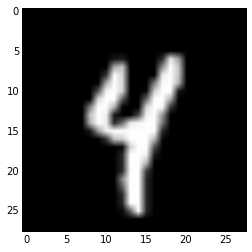

In [124]:
plt.imshow(to_image(batch)[0]);

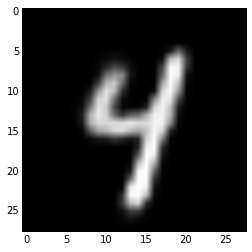

In [125]:
sample_images = generate_state(batch, 500) #15
plt.imshow(to_image(sample_images)[0]);

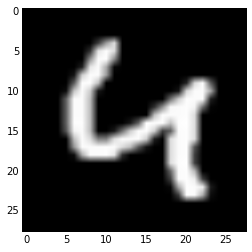

In [126]:
plt.imshow(to_image(batch)[2]);

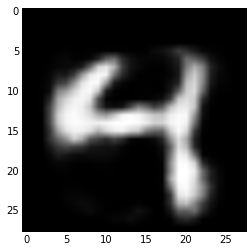

In [127]:
plt.imshow(to_image(sample_images)[2]);

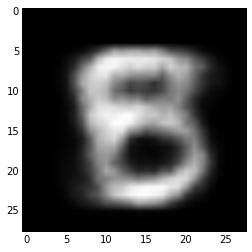

In [128]:
#run gibbs sampling from random inputs
random_gibbs_images = generate_state(np.random.random(size=[BATCH_SIZE,IMAGE_HEIGHT*IMAGE_WIDTH]), 200)
plt.imshow(to_image(random_gibbs_images)[0]);

In [21]:
W.eval()

array([[-0.01409554, -0.00536683, -0.00565238, ...,  0.01831558,
        -0.00584126, -0.00820349],
       [ 0.00997176,  0.01120596, -0.00595941, ...,  0.01863942,
        -0.00650183,  0.00103016],
       [ 0.01185286, -0.00741214,  0.00017319, ..., -0.01414159,
         0.01406672, -0.00414365],
       ..., 
       [-0.00112381,  0.00889921, -0.00948953, ..., -0.01556171,
         0.00801014,  0.0082342 ],
       [-0.00777897, -0.00974959, -0.01762774, ..., -0.00301312,
         0.00079663, -0.01516621],
       [ 0.01714878,  0.00978682, -0.01005803, ..., -0.01142717,
        -0.00302883, -0.01486796]], dtype=float32)

In [22]:
np.max(np.abs(W.eval()))

2.4584517

In [23]:
a_vals = a.eval()
a_vals = a_vals*(np.abs(a_vals)<1.0e38).astype(float) #kill off ridiculously high biases

In [24]:
np.max(np.abs(a_vals))

1000.0

In [25]:
np.min(np.abs(a_vals))

0.0012470795772969723

In [26]:
np.max(np.abs(b.eval()))

1.6849988

In [27]:
np.min(np.abs(b.eval()))

1.5832484e-08

In [28]:
np.min(np.abs(W.eval()))

7.4040145e-08

In [20]:
start_state = batch
hidden_probs = sess.run(h_prob, feed_dict={v_state: start_state})
hidden_state = sess.run(h_prob_to_state, feed_dict={h_probabilities: hidden_probs})

visible_probs = sess.run(v_prob, feed_dict={h_state: hidden_state})
visible_state = sess.run(v_prob_to_state, feed_dict={v_probabilities: visible_probs})

In [21]:
np.max(hidden_probs[0]-hidden_probs[7])

1.0

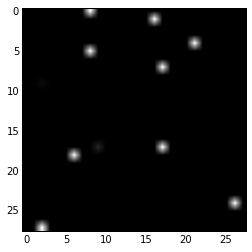

In [22]:
plt.imshow(to_image(hidden_probs)[7]);

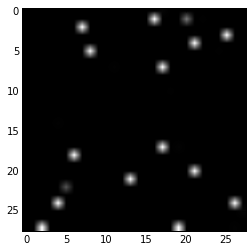

In [23]:
plt.imshow(to_image(hidden_probs)[0]);

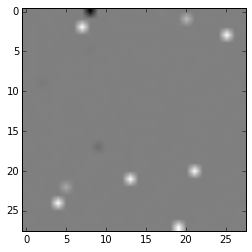

In [24]:
plt.imshow(to_image(hidden_probs[0]-hidden_probs[7]))